**motivation**<br>
Edwin Chen explains LSTM <a href="http://blog.echen.me/2017/05/30/exploring-lstms/">here</a> through a counting example. In this notebook I code up his example to see for myself what hidden neurons do in LSTM. More specifically, when sentences of the form "aXb", "aaXbb", "aaaXbbb", up to 10 a's and 10 b's, are shown to an LSTM model, it will learn the pattern, and when it sees longer sentences like "aaaaaaaaaaaXbb", it knows to keep adding "b" to it until the number of b's matches the number of a's.

**load packages**

In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import matplotlib.pyplot as plt
import pickle
import sys
import heapq
from pylab import rcParams
import io
import os
import random
import seaborn as sns; sns.set()
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 12, 5

Using TensorFlow backend.


**set up training data**

In [2]:
# generate raw training data, 'E' is for end of sentence
raw_data = []
for i in range(10):
    raw_data.append('a'*(i+1) + 'X' + 'b'*(i+1) + 'E')

In [3]:
# generate sentences and next characters off of raw training data
sentences = []
next_chars = []
for i in range(len(raw_data)):
    s = raw_data[i]
    for j in range(i+2):
        sentences.append(s[:(i+2+j)])
        next_chars.append(s[i+2+j])    

In [4]:
# collect unique characters; define character to index dictionary and index to character dictionary
chars = ['a', 'b', 'X', 'E']
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

In [5]:
# prepare input for training
def prepare_input(text):
    '''
    text: a sentence
    return: an array with dimension (1, length of text, 4)
    '''
    x = np.zeros((1, len(text), len(chars)))
    for t, char in enumerate(text):
        if char in chars: 
            x[0, t, char_indices[char]] = 1.
        else: # deal with characters not in train data
            x[0, t] = 0.
    return x

In [6]:
# prepare labels for training
def prepare_output(char):
    '''
    char: a character
    return: an array with dimension (1, 4)
    '''
    y = np.zeros((1, len(chars)))
    y[0, char_indices[char]] = 1
    return y

In [7]:
# set up training data, to be fed to LSTM
sequences = []
y = []
for i in range(len(sentences)):
    sequences.append(prepare_input(sentences[i]))
    y.append(prepare_output(next_chars[i]))

**training**

In [8]:
# set up an LSTM model with 10 hidden neurons
model = Sequential()
model.add(LSTM(10, input_shape=(None, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [9]:
# train the model for 20 epochs; 
# in each epoch, train on one example at a time because the examples have various lengths
num_epochs = 20
for j in range(num_epochs):    
    for i in range(len(sequences)):
       model.fit(sequences[i], y[i], verbose=0)

In [10]:
# save the model
home = os.getenv('HOME')
model.save(home + '/Deep_Learning_Examples/LSTM/keras_model_counting_20_epochs_git.h5')

**trainable parameters**<br>
Christopher Olah's great <a href="https://colah.github.io/posts/2015-08-Understanding-LSTMs/">blog post</a>, explains step by step how forget gate, input gate, update gate, and output gate work in LSTM.

In [11]:
# load model
# the model saved above may be different each time we train the model. I didn't try to make it reproducible
# instead, I'll load a model I trained and saved earlier
model = load_model(home + '/Deep_Learning_Examples/LSTM/keras_model_counting_20_epochs.h5')

In [12]:
# the lstm layer has 600 parameters; the dense layer has 44 parameters
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 10)                600       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 44        
_________________________________________________________________
activation_2 (Activation)    (None, 4)                 0         
Total params: 644
Trainable params: 644
Non-trainable params: 0
_________________________________________________________________


In [13]:
# fully connected layer, number of parameters
a = len(chars)*10 + len(chars)
a

44

In [14]:
# lstm layer, number of parameters for one of four gates (forget gate, input gate, update gate, output gate)
b = (10*10 + 10*len(chars) + 10)
b*4

600

**making predictions**<br>
The model is trained on examples containing up to 10 a's and 10 b's. In this section we test the model's ability to complete sentences with more than 10 a's.

In [15]:
def sample(preds, top_n=3):
    '''
    preds: 4 dimensional array of probabilities assigned to each character
    return: indices of characters receiving the highest probabilities upto top_n characters
    '''
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

def predict_completion(text):
    '''
    text: a complete or incomplete sentence
    return: the model keeps adding characters to text until character "E" is chosen
    '''
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text + next_char
        completion += next_char
        
        if next_char == 'E':
            return completion

In [16]:
# in this example the text is already complete, so next_char predicted should be "E"
x = prepare_input('aaXbb')
preds = model.predict(x, verbose=0)[0]
next_index = sample(preds, top_n=1)[0]
next_char = indices_char[next_index]
next_char

'E'

In [17]:
# in this example according to the pattern the model should add 23 b's followed by an "E", which it did!
text = 'aaaaaaaaaaaaaaaaaaaaaaaX'
predict_completion(text), len(predict_completion(text)), len(text)

('bbbbbbbbbbbbbbbbbbbbbbbE', 24, 24)

In [18]:
# things break when there's 24 a's!
text = 'aaaaaaaaaaaaaaaaaaaaaaaaX'
predict_completion(text), len(predict_completion(text)), len(text)

('bbbbbbbbbbbbbbbbbbbbbbbE', 24, 25)

**visualizing activations of neurons**<br>
There are 10 hidden neurons in our model. In this section we trace their activations to see what they are doing.

In [19]:
# extract LSTM weights, with forget gate, input gate, output gate, and update gate all stacked together
for layer in model.layers:
        if "LSTM" in str(layer):
            weightLSTM = layer.get_weights()

In [20]:
# use hard_sigmoid to define the sigmoid function 
# see https://github.com/keras-team/keras/blob/master/keras/layers/recurrent.py#L1751:
def sigmoid(x):
    if x < -2.5:
        return 0.0
    elif x > 2.5:
        return 1.0
    else:
        return 0.2*x + 0.5
sigmoid = np.vectorize(sigmoid)    

In [21]:
def LSTMlayer(weight,x_t,h_tm1,c_tm1):
    '''
    weight: weight from LSTM layer
    x_t: current input
    h_tm1: previous hidden state (tm1 stands for t minus 1)
    c_tm1: previous cell state
    return: current hidden state and cell state
    
    hunits: number of hidden units, i.e. number of neurons in hidden layer
    nfeatures: number of distinct characters
    c_tm1 = np.array([0]*hunits).reshape(1,hunits), this is the shape of c_tm1
    h_tm1 = np.array([0]*hunits).reshape(1,hunits), this is the shape of h_tm1
    x_t = np.array([0]*nfeature).reshape(1,nfeatures), this is the shape of x_t
    
    warr.shape = (nfeatures,hunits*4)
    uarr.shape = (hunits,hunits*4)
    barr.shape = (hunits*4,)
    '''
    warr, uarr, barr = weight
    s_t = (x_t.dot(warr) + h_tm1.dot(uarr) + barr) # (1,4)x(4, 40) + (1,10)x(10,40) + (40,); OK to add (1,40) and (40,)
    hunit = uarr.shape[0]
    i  = sigmoid(s_t[:,:hunit])
    f  = sigmoid(s_t[:,1*hunit:2*hunit])
    _c = np.tanh(s_t[:,2*hunit:3*hunit])
    o  = sigmoid(s_t[:,3*hunit:])
    c_t = i*_c + f*c_tm1
    h_t = o*np.tanh(c_t)
    return(h_t,c_t)

In [22]:
def get_hidden(xs):
    '''
    xs: a sentence
    return: a list of hidden state arrays, one array per character
    '''
    x = prepare_input(xs)
    warr, uarr, barr = weightLSTM
    hunits = uarr.shape[0]
    c_tm1 = np.array([0]*hunits).reshape(1,hunits)
    h_tm1 = np.array([0]*hunits).reshape(1,hunits)
    nfeatures = warr.shape[0]

    hidden=[]
    for i in range(len(xs)):
        x_t = x[0][i].reshape(1,nfeatures)
        h_tm1,c_tm1 = LSTMlayer(weightLSTM,x_t,h_tm1,c_tm1)
        hidden.append(h_tm1)
    return hidden    

In [23]:
def get_neuron(neuron, xs):
    '''
    neuron: which neuron we want to look at
    xs: a sentence
    return: the neuron's activation corresponding to the characters in xs
    '''
    hidden = get_hidden(xs)
    activation = [hidden[i][0][neuron] for i in range(len(xs))]
    return activation

In [24]:
def pad_list(a):
    '''
    pad the list a with 0 until the length of a is 21
    '''
    return a + [0] * (21 - len(a))

In [25]:
def get_df(neuron, sentences):
    '''
    neuron: which neuron we want to look at
    sentences: what sentences we want to include
    return: a dataframe of neuron activations for each sentence in sentences
    '''
    big_list = []
    for sentence in sentences:
        small_list = get_neuron(neuron, sentence)
        small_list = pad_list(small_list)
        big_list.append(small_list) 
    df = pd.DataFrame(big_list)
    return df

In [26]:
# plot heatmap of the activations of the neurons
def plot_heatmap(df, yticklabel=True, linewidth=0.5, annot_size=10, width=15, height=8):
    plt.subplots(figsize=(width,height))
    cmap=mcolors.LinearSegmentedColormap.from_list("n",['#ba2832', '#e48066', '#fbccb4', '#f7f6f6', '#c2ddec', '#6bacd1', '#2a71b2'])
    norm = plt.Normalize(-1,1)
    ax = sns.heatmap(df, cmap=cmap, norm=norm, yticklabels=yticklabel, linewidths=linewidth, annot=True, annot_kws={"size": annot_size})
    plt.show()    

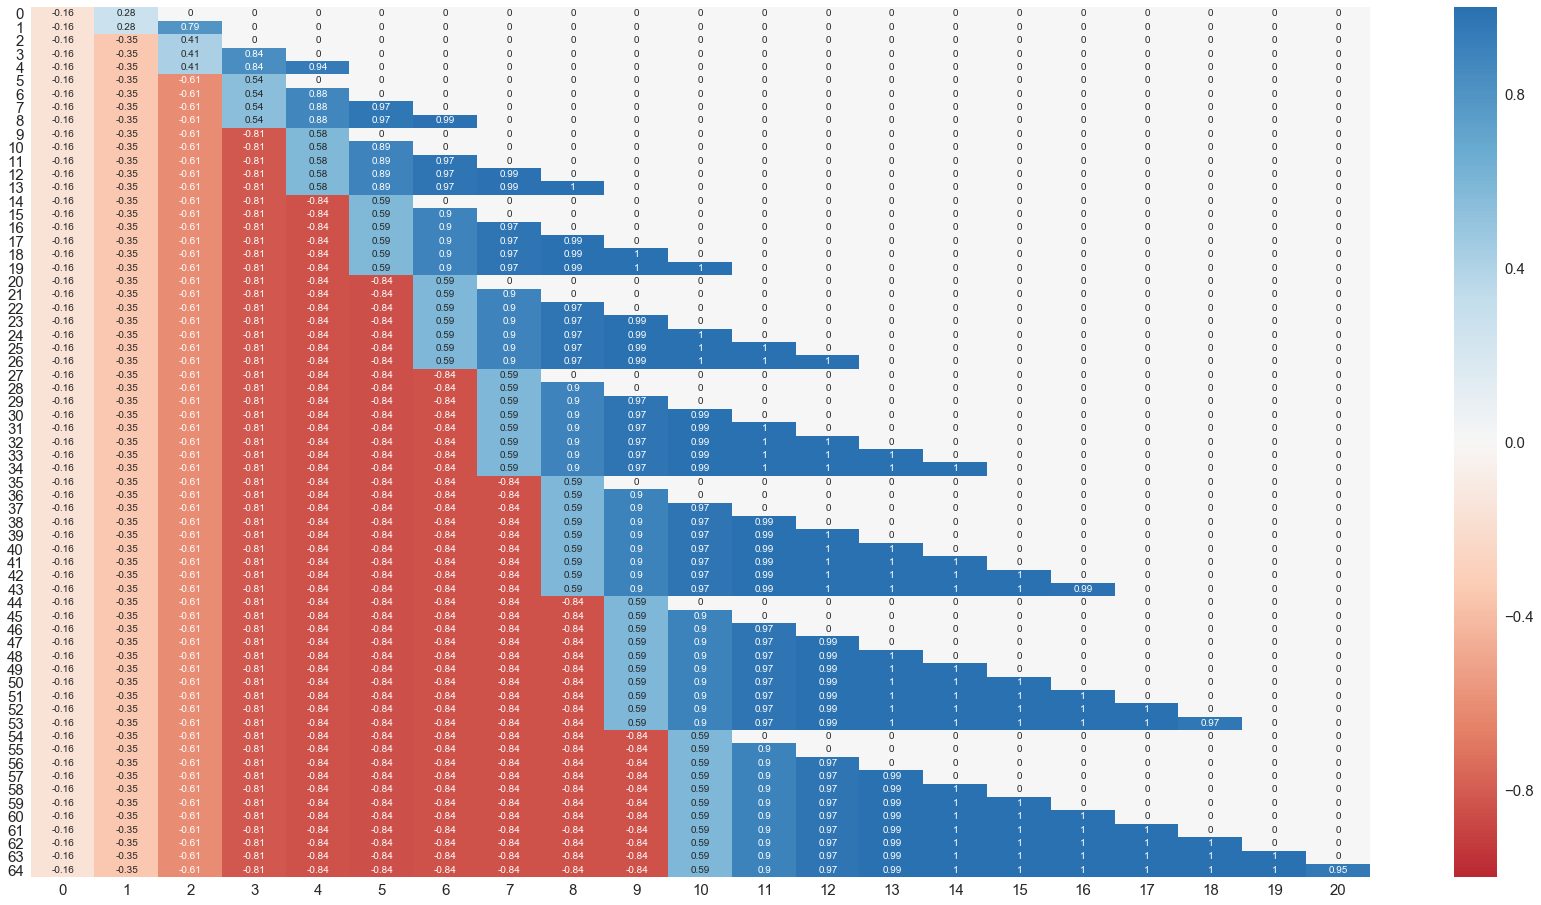

In [27]:
# plot neuron 0's activation values for all sentences
# neuron 0 is tracking the number of a's and b's
plot_heatmap(get_df(0, sentences), yticklabel=True, linewidth=0, annot_size=10, width=30, height=16)

In [28]:
# reshape each array in get_hidden(xs) to make it a dataframe
xs  = 'aaaaaaXbbbbbb'
hidden = [h.reshape(model.layers[1].get_weights()[0].shape[0],) for h in get_hidden(xs)]

# each column is a hidden state, from the first character to the last character in a sentence
# from left to right, it shows how the hidden state evolves over time as we progress along the sentence
name = np.arange(1,(len(get_hidden(xs))+1),1).tolist()
pd.DataFrame.from_items(zip(name, hidden))

,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-0.161908,-0.349095,-0.606356,-0.814184,-0.839314,-0.844281,0.587401,0.896963,0.973821,0.993132,0.998045,0.999200,0.999409
1,-0.038228,-0.165867,-0.259795,-0.233565,-0.207687,-0.195035,-0.000193,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.004207
2,-0.201752,-0.419343,-0.603480,-0.704154,-0.727378,-0.733204,-0.999856,-0.999243,-0.980494,-0.952734,-0.882928,-0.612983,-0.098589
3,0.024792,0.043306,0.026118,0.000000,0.000000,0.000000,0.738255,0.593455,0.632193,0.615142,0.367193,-0.152161,-0.492809
4,0.105505,0.304588,0.512437,0.631565,0.675870,0.682678,0.643581,0.409422,0.440461,0.441086,0.441353,0.453515,0.443786
5,-0.174903,-0.490868,-0.790441,-0.945278,-0.977938,-0.987664,-0.943305,-0.999739,-0.998101,-0.986166,-0.902843,-0.455928,0.434261
6,0.057625,0.048684,-0.011966,-0.077449,-0.129707,-0.165201,-0.601786,-0.404216,-0.404817,-0.372074,-0.318065,-0.232765,-0.063405
7,-0.151498,-0.415795,-0.793586,-0.966596,-0.993623,-0.998807,-0.999750,-0.999643,-0.999203,-0.998007,-0.994931,-0.960994,-0.765806
8,-0.119036,-0.364742,-0.622729,-0.752349,-0.798519,-0.803373,-0.695516,-0.089493,0.117687,0.132879,0.135970,0.132668,0.124573
9,0.144347,0.372625,0.486390,0.469127,0.440222,0.427423,0.345057,0.011862,0.035770,0.042994,0.049328,0.077218,0.174314


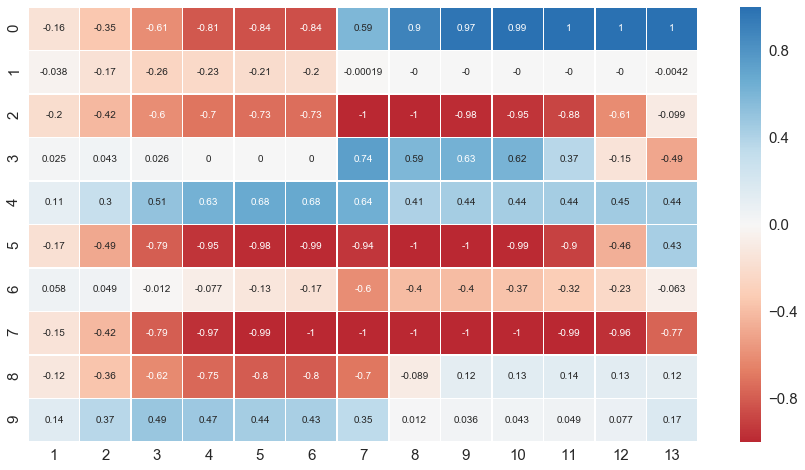

In [29]:
# visualize the above dataframe
hidden_states = pd.DataFrame.from_items(zip(name, hidden))
plot_heatmap(hidden_states)

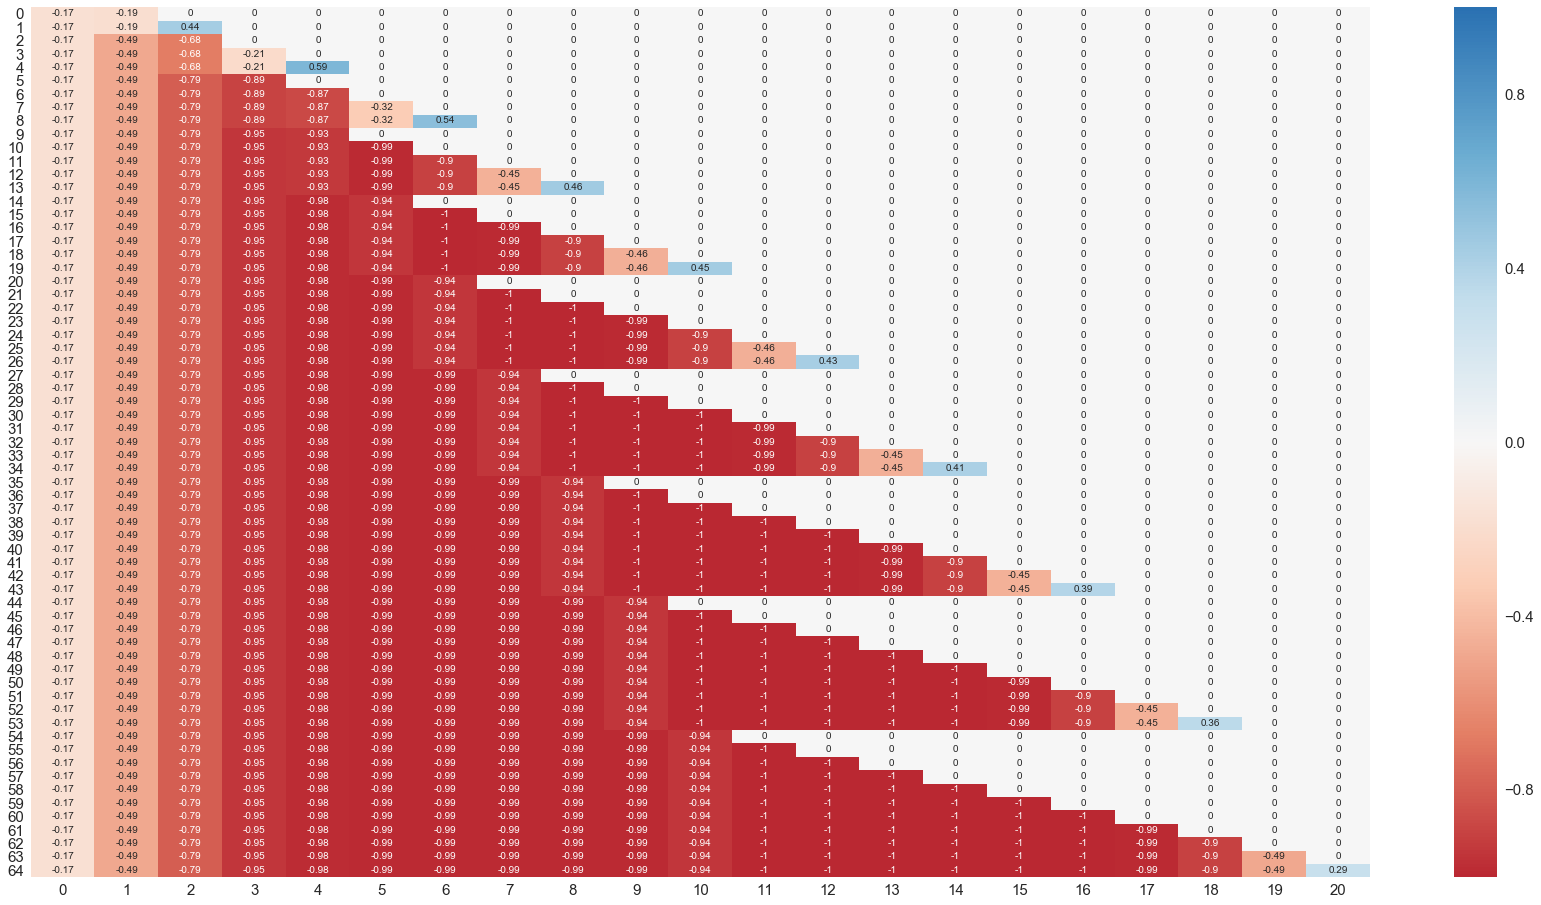

In [30]:
# Neuron 0 alone is not enough to make the end-of-sentence prediction
# It just keeps approaching 1 once we are in the b territory
# To make it stop, it seems that we also need neuron 5
# take a look at neuron 5 for all sentences
plot_heatmap(get_df(5, sentences), yticklabel=True, linewidth=0, annot_size=10, width=30, height=16)

**how about we train the LSTM using only one neuron to begin with?**<br>
It seems that neuron 0 tracks the number of a's and b's, but neuron 5 tracks when the sentence stops. Neuron 5 alone is enough for the counting problem, what if we train the LSTM using only one neuron? Will it become neuron 5?

In [31]:
# You can train the model with only one neuron. Here I load a pre-trained model
model = load_model(home + '/Deep_Learning_Examples/LSTM/keras_model_counting_300_epochs_one_neuron.h5')

In [32]:
for layer in model.layers:
        if "LSTM" in str(layer):
            weightLSTM = layer.get_weights()

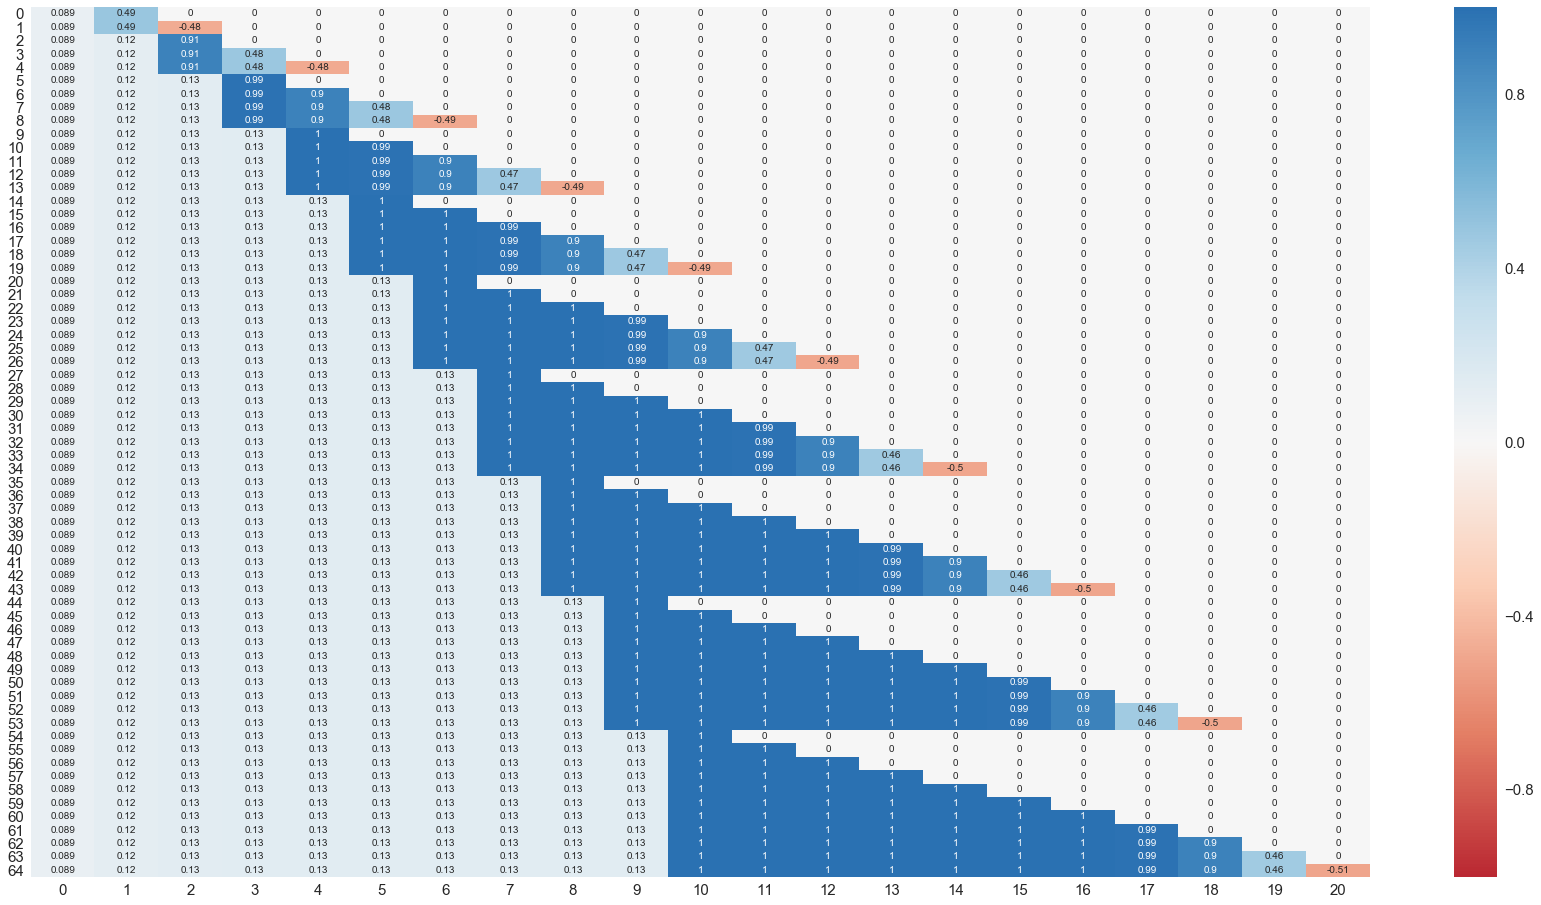

In [33]:
# The single neuron did become neuron 5!
plot_heatmap(get_df(0, sentences), yticklabel=True, linewidth=0, annot_size=10, width=30, height=16)

**Learnings**<br>
1. 65 sentences, 10 are complete, 55 are incomplete
2. these sentences are fed to an LSTM model, one at a time because they have different lengths
3. one neuron (neuron 0) tracks the number of a's and b's
4. another neuron (neuron 5) tracks when the sentence stops
5. neuron 5 alone is enough for the counting problem
6. it takes much longer to train a one neuron LSTM than a ten neuron LSTM though
7. upshot: what do hidden neurons do in LSTM? they encode raw data into different features